<a href="https://colab.research.google.com/github/aturocks/XSAnno_run/blob/main/XSAnno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**XSAnno Run**

#Created by: Atreyo Pal
#Last edit: 06/14/2024
##Colab link: https://colab.research.google.com/drive/1PH0CuCWVsE2jklv-LfmITzXXj3fCD1GV?usp=sharing

## **Step 1: Reciprocal liftOver**

1. Unzip XSAnno.zip and load up all dependencies (BLAT, Python, R, ucsc-tools).

2. Install dependencies and convert primary annotation file to required format.
```
cd XSAnno/
chmod 755 bin/AnnoConvert
chmod 755 bin/BlatFilter
export PATH=./bin:$PATH
chmod +x convert_gtf_to_bed.sh
./convert_gtf_to_bed.sh native_gtf/gencode.v43.basic.annotation.gtf.gz \
native_gtf/gencode.v43.basic.annotation.bed
```

3. Before running step 1, download requisite human and chimpanzee fasta files (analysisSet without patched info like chr_fix or chr_alt) and do a supplementary analysis to determine best liftOver -minMatch parameter when going from hg38 to panTro6.
```
mkdir -p fasta
cd fasta
wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/analysisSet/hg38.analysisSet.fa.gz
mv hg38.analysisSet.fa.gz hg38.fa.gz
gunzip hg38.fa.gz
cp panTro6.fa ./
mkdir -P supplementary
wget https://hgdownload.soe.ucsc.edu/goldenPath/panTro6/vsHg38/ \
reciprocalBest/axtRBestNet/panTro6.hg38.rbest.axt.gz
wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/vsPanTro6/ \
reciprocalBest/axtRBestNet/hg38.panTro6.rbest.axt.gz
gunzip panTro6.hg38.rbest.axt.gz
gunzip hg38.panTro6.rbest.axt.gz
perl ../../bin/perl_lib/liftOverBlockSim.pl \
 -i hg38.panTro6.rbest.axt,panTro6.hg38.rbest.axt \
 -o liftOverBlock_simulation_output.txt -b 150 -n 1000
Rscript ../../example_scripts/plot_liftOverBlockSim.r \
liftOverBlock_simulation_output.txt output_plot.pdf
# best -minMatch = 0.98 from median value shown in the output_plot.pdf
```



4.  Generate LiftOver Annotation based on annotation of human (GENCODEv43). Make sure the needed chain files are downloaded.
```
cd ../../Annoconvert_testing/
../bin/AnnoConvert ../bin/perl_lib/ ../native_gtf/gencode.v43.basic.annotation.bed \
../annoconvert_files/hg38ToPanTro6.over.chain.gz \
../annoconvert_files/panTro6ToHg38.over.chain.gz .98 . hg38 panTro6 N
# generates two output files: hg38.hg38_panTro6.liftOver.bed and panTro6.hg38_panTro6.liftOver.bed which must be used as input for next step (BLAT).
```

## **Step 2: BLAT filtering**
1. Download requisite 2bit files for human and chimpanzee genomes in preparation of next step. Use the fasta files from step 1.3 to make the 11ooc files to speed up local alignment in next step (BLAT).
```
mkdir -p ../blat_files
cd ../blat_files
wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/analysisSet/hg38.analysisSet.2bit
mv hg38.analysisSet.2bit hg38.2bit
wget https://hgdownload.soe.ucsc.edu/goldenPath/panTro6/bigZips/panTro6.2bit
blat ../fasta/hg38.fa /dev/null /dev/null -makeOoc=hg38.11ooc -tileSize=11
blat ../fasta/panTro6.fa /dev/null /dev/null -makeOoc=panTro6.11ooc -tileSize=11
```
2. There is a particular script `intervals2sequences.c` which is missing from the `bin` folder of XSAnno. It is from the RSEQTools package; website http://archive.gersteinlab.org/proj/rnaseq/rseqtools/. However, this website is archived, so I could not download the file from their source code folder even after trying multiple times (Chrome says site can't be reached and timed out every time). This means I can't download the C packages and dependencies required to run their script. So I went to their Github https://github.com/gersteinlab/RSEQtools/blob/master/mrf/ and manually re-wrote their `interval2sequences.c` in Python (script below). Make sure to put this `interval2sequences.py` script in the `bin` folder before proceeding and change the line in the `bin/BlatFilter` script to refer to this script.

3. Another discrepancy I found was between the XSAnno_v2 folder (https://hbatlas.org/xsanno/files/XSAnno_v2.zip) and XSAnno_v1 folder (https://github.com/YingZhuLab/XSAnno/tree/master). Please use the folder from Github, as the `bin/filter_alignments.pl` script is correct there (and incorporates the Blat_scores perl module correctly).

4. Perform local alignment between species and within species using BLAT. Parameters chosen are the same as XSAnno paper: % ID between species = 95%, % len between species = 95%, % ID within species = 97%, % len within species = 95%. Converted Severin's `blatFilter_byTranscript.R` (which performs additional filtering of % len within species >= 97% based on his testing) to our format of the annotation column having 5 entries instead of 4.
NOTE: Severin used the wrong liftOver input for the chimpanzee bed file in the BlatFilter wrapper command step, this script fixes that in accordance with the XSAnno manual.
```
mkdir -p ../BLAT_testing2
cd ../BLAT_testing2
../bin/BlatFilter ../blat_files/hg38.2bit ../blat_files/panTro6.2bit \
../Annoconvert_testing/hg38.hg38_panTro6.liftOver.bed \
../Annoconvert_testing/panTro6.hg38_panTro6.liftOver.bed \
 .95 .95 .97 .95 ../bin/perl_lib . hg38 panTro6 \
 ../blat_files/hg38.11ooc ../blat_files/panTro6.11ooc
mkdir -p blatfilter_by_transcript
cd blatfilter_by_transcript
Rscript blatFilter_byTranscript_AP_new.R
# gives two output files blatFiltered.hg38TopanTro6.hg38.bed
# and blatFiltered.hg38TopanTro6.panTro6.bed
```

## **Step3: Differential exon filtering**
1. Load simNGS package with dependencies
```
cd ~/palmer_scratch
wget https://www.ebi.ac.uk/goldman-srv/simNGS/current/simNGS.tgz
tar -xvf simNGS.tgz
cd simNGS/src
module purge
ml miniconda
conda create -n simngs libblas liblapack gcc
conda activate simngs
make -f Makefile.linux
```
2. Run simNGS to simulate SE reads; 10 human, 10 chimp samples; based on the WGA alignment (liftOver output). NOTE: this diverges from Severin's script and uses the liftOver output bed file (not the BlatFilter output bed file) as the input for this step, and is in line with the XSAnno paper. Illumina-like intensity calls (used by simNGS) were downloaded from https://github.com/timmassingham/simNGS/tree/master/data
```
mkdir -p Sim_testing
cd Sim_testing
getfasta -fi ../fasta/hg38.fa -bed ../Annoconvert_testing/hg38.hg38_panTro6.liftOver.bed \
 -s -name >liftover.cDNA.hg38TopanTro6.hg38.fa
getfasta -fi ../fasta/panTro6.fa -bed ../Annoconvert_testing/panTro6.hg38_panTro6.liftOver.bed \
 -s -name >liftover.cDNA.hg38TopanTro6.panTro6.fa
./simngs_script.sh
```
3. Make HiSat2 indexes and run HiSat2 on simulated reads. After alignment, we then quantify exon abundance using Stringtie, but only for the exons that pass the BlatFilter step. This is again in line with the XSAnno paper. For this we convert the blatFiltered.hg38TopanTro6.hg38.bed and blatFiltered.hg38TopanTro6.panTro6.bed files produced after the BlatFilter step to a gtf to put into Stringtie. Finally, we convert the Stringtie output into a counts matrix required for DESeq2.
```
ml HISAT2
# make sure ucsc-bedToGenePred and ucsc-genePredToGtf are in your conda environment
bedToGenePred ../BLAT_testing2/blat/blatfilter_by_transcript/blatFiltered.hg38TopanTro6.hg38.bed \
 blatFiltered.hg38TopanTro6.hg38.genePred
genePredToGtf "file" blatFiltered.hg38TopanTro6.hg38.genePred \
 -source=XSanno blatFiltered.hg38TopanTro6.hg38.gtf
awk '$3 == "exon"' blatFiltered.hg38TopanTro6.hg38.gtf > blatFiltered.hg38TopanTro6.exon.hg38.gtf
bedToGenePred ../BLAT_testing2/blat/blatfilter_by_transcript/blatFiltered.hg38TopanTro6.panTro6.bed \
 blatFiltered.hg38TopanTro6.panTro6.genePred
genePredToGtf "file" blatFiltered.hg38TopanTro6.panTro6.genePred \
 -source=XSanno blatFiltered.hg38TopanTro6.panTro6.gtf
awk '$3 == "exon"' blatFiltered.hg38TopanTro6.panTro6.gtf > blatFiltered.hg38TopanTro6.exon.panTro6.gtf
cd ~/palmer_scratch/XSAnno/Hisat2_indexes
hisat2-build -p 10 ../fasta/hg38.fa hg38_index/hg38
hisat2-build -p 10 ../fasta/panTro6.fa panTro6_index/panTro6
cd ../Sim_testing
./rna_seq_sim.sh
cd stringtie
python3 prepDE.py3 -i sample_list_pt.txt
python3 prepDE.py3 -i sample_list_hs.txt
./merge_exon_counts_matrices.sh
# produces output counts matrix exon_count_matrix_hs_pt.txt
```
4. Run DESeq2 on the combined counts matrix and remove any differentially expressed exon (padj < 0.01). In particular, we filter these exons out from the BlatFilter output bed file. The bed file with exons that remain after this step is then converted to the final GTF file (via my first ever Perl script!).
```
Rscript simFilter_by_DEX_AP.r
cd ../final_gtf
perl bed2gtf_AP.pl ../stringtie/simFiltered.hg38TopanTro6.hg38.bed >XSAnno_hg38TopanTro6_hg38.gtf
perl bed2gtf_AP.pl ../stringtie/simFiltered.hg38TopanTro6.panTro6.bed >XSAnno_hg38TopanTro6_panTro6.gtf
```




#**QC results**

##**Output plot to determine liftOver minMatch (hg38 vs panTro6)**

In [ ]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving XSAnno_mismatch_plot.png to XSAnno_mismatch_plot.png


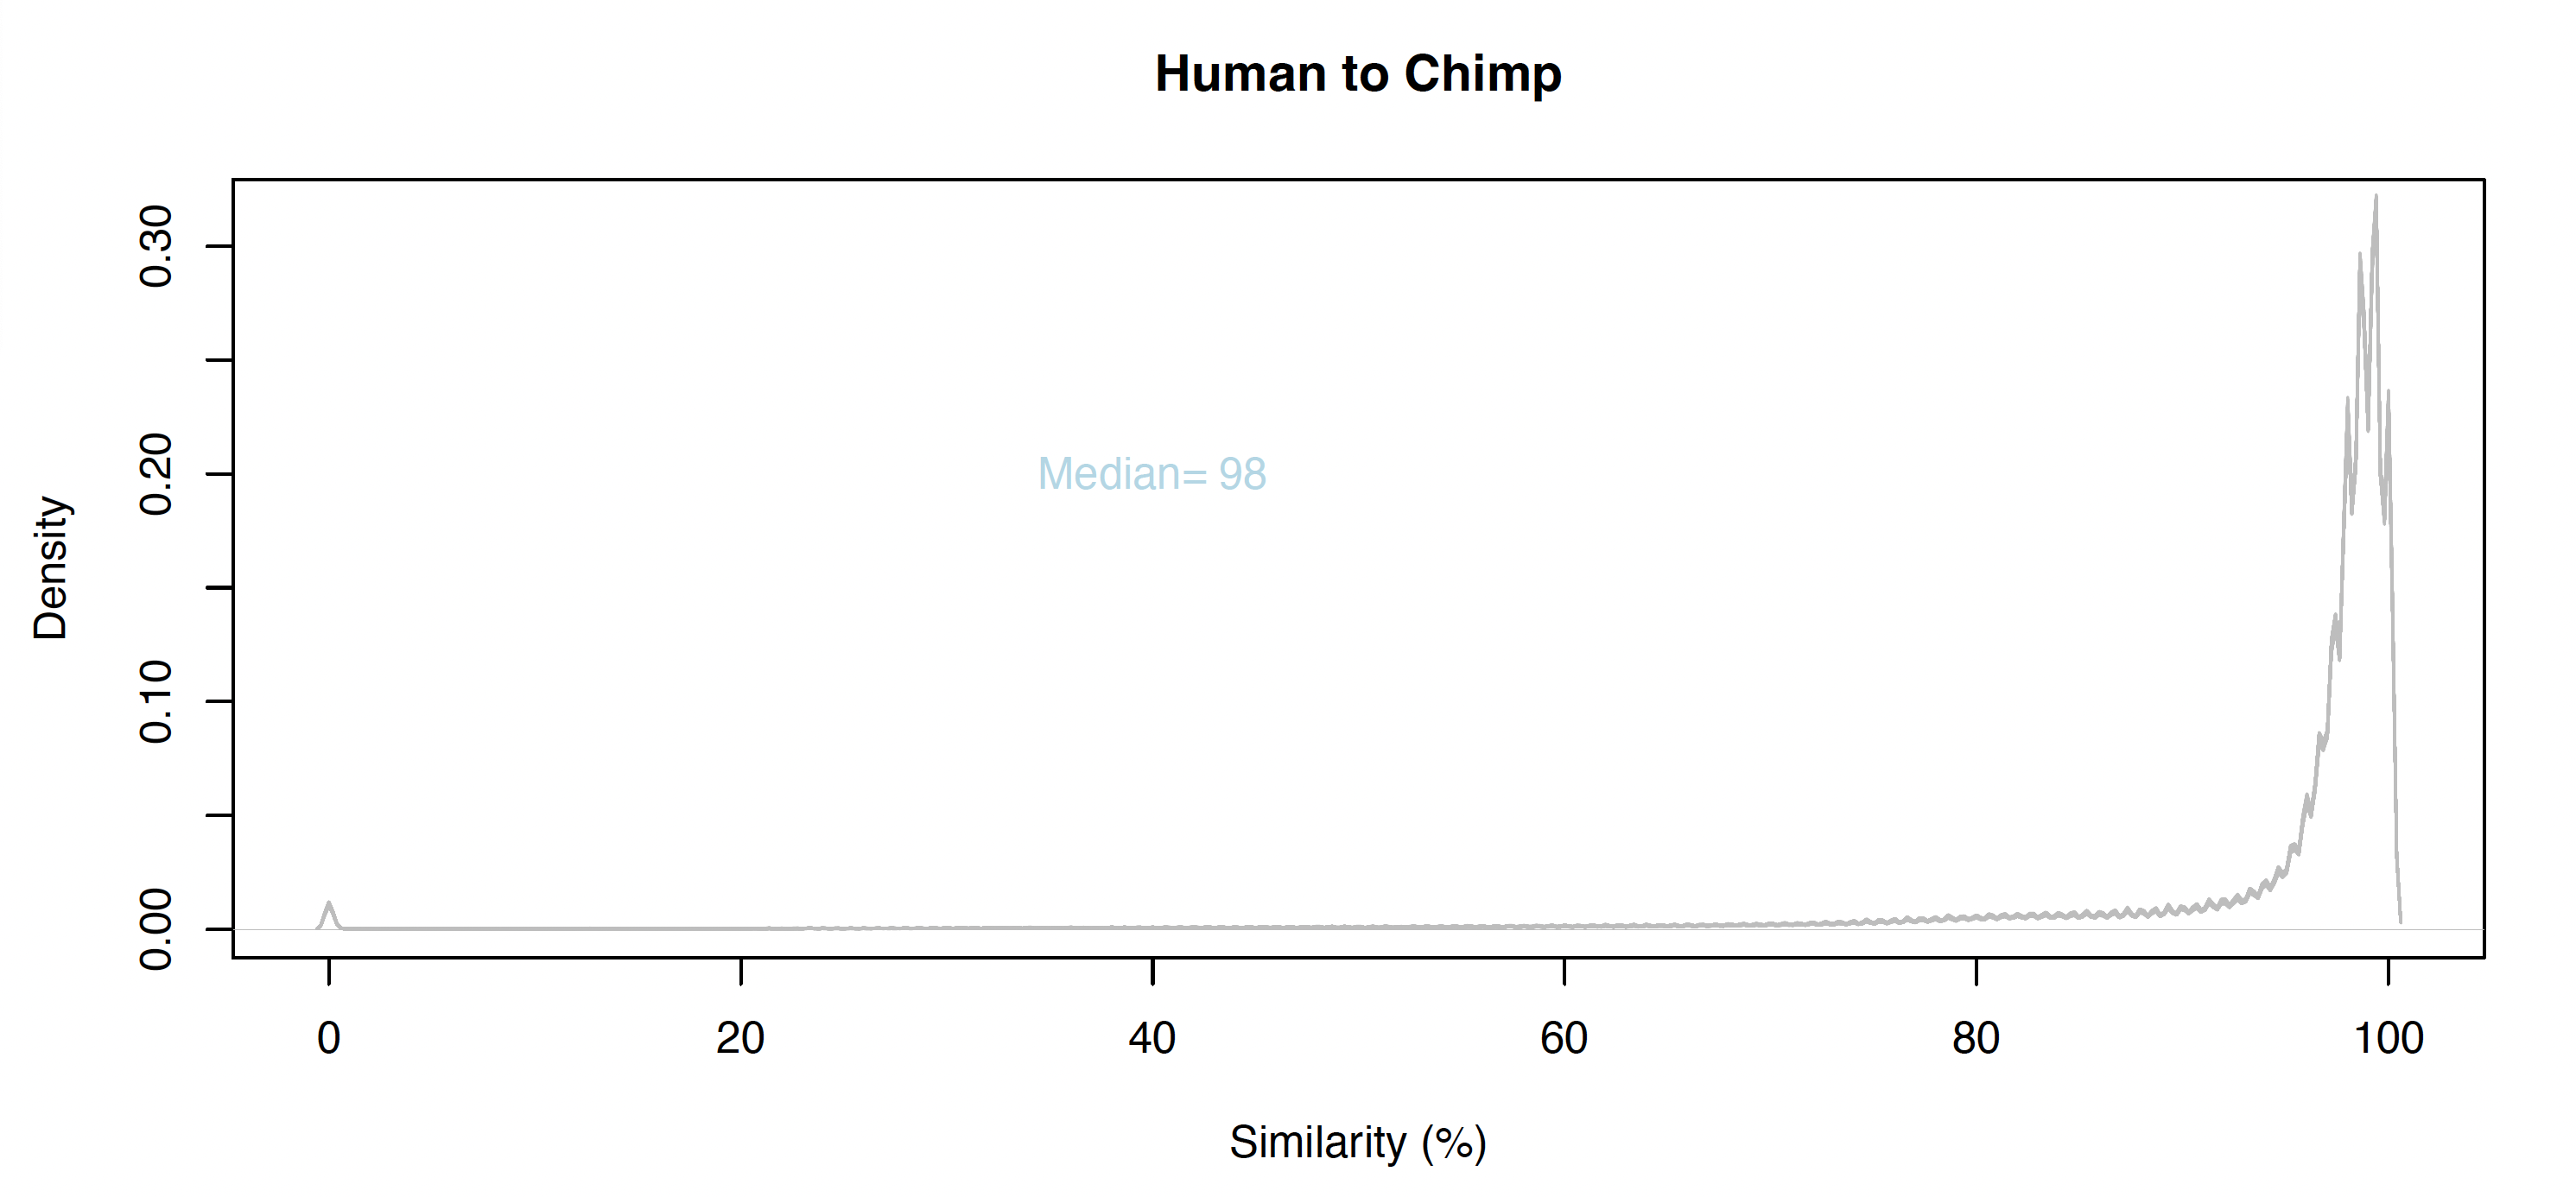

In [ ]:
Image('XSAnno_mismatch_plot.png')

##**Summary statistics**

1. The number of exons in the original gencode.v43.bed file: 853536, the number of genes in the original gencode.v43.bed file: 61217

2. The number of exons after reciprocal liftover: 801870, the number of genes after reciprocal liftover: 55789

3. The number of exons after BLAT filtering: 707722, the number of genes after BLAT filtering: 49879

4. The number of exons after differential exon filtering: 702411, the number of genes after differential exon filtering: 49813

In [ ]:
from google.colab import files
uploaded1 = files.upload()

Saving n_breakdwon_by_gene_type_after_fix.csv to n_breakdwon_by_gene_type_after_fix.csv


In [ ]:
import pandas as pd
df = pd.read_csv('n_breakdwon_by_gene_type_after_fix.csv')
display(df)

,Unnamed: 0,gene_type,n.before_liftover,n.after_liftover,n.after_BLAT,n.after_DE
0,1,IG_C_gene,14,14,6,6
1,2,IG_C_pseudogene,9,6,4,4
2,3,IG_D_gene,37,5,0,0
3,4,IG_J_gene,18,8,4,4
4,5,IG_J_pseudogene,3,0,0,0
5,6,IG_V_gene,145,74,43,43
6,7,IG_V_pseudogene,187,99,63,62
7,8,IG_pseudogene,1,0,0,0
8,9,Mt_rRNA,2,2,0,0
9,10,Mt_tRNA,22,22,0,0


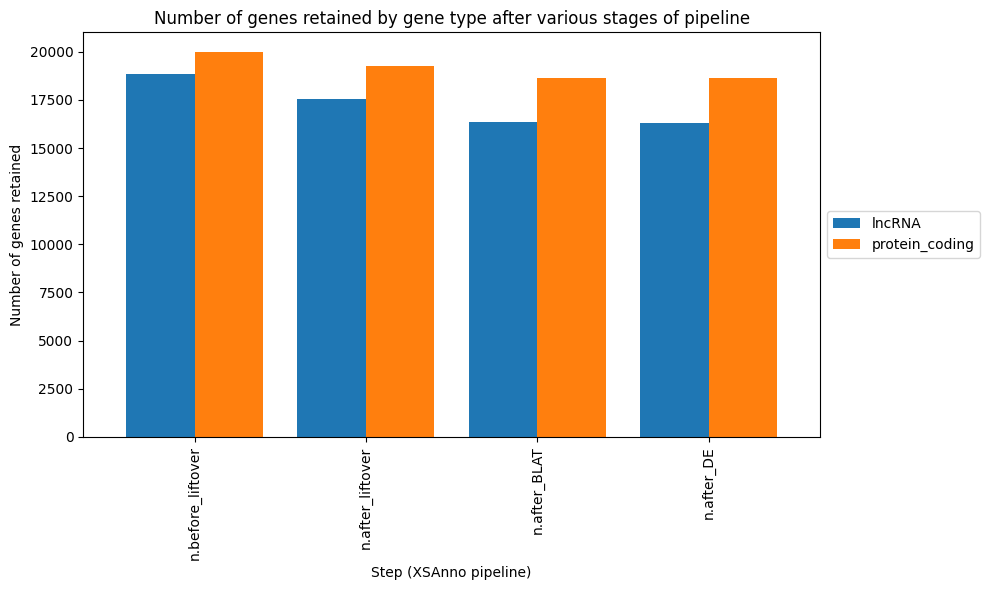

In [ ]:
import matplotlib.pyplot as plt

# Filter the dataframe to include only the relevant rows and columns
df_filtered = df[df['gene_type'].isin(['protein_coding', 'lncRNA'])]
df_filtered = df_filtered[['gene_type', 'n.before_liftover', 'n.after_liftover', 'n.after_BLAT', 'n.after_DE']]

# Group the data by gene_type and calculate the sum of each category
df_grouped = df_filtered.groupby('gene_type').sum()

# Transpose the dataframe for better plotting
df_grouped = df_grouped.T

# Create a bar plot with the transposed dataframe
ax = df_grouped.plot(kind='bar', figsize=(10, 6), width=0.8)

# Set legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add labels and title
ax.set_xlabel('Step (XSAnno pipeline)')
ax.set_ylabel('Number of genes retained')
ax.set_title('Number of genes retained by gene type after various stages of pipeline')

# Show the plot
plt.tight_layout()
plt.show()


# **Supplementary scripts used**
#**convert_gtf_to_bed.sh script**



```
#!/bin/bash

# Usage: ./convert_gtf_to_bed.sh input.gtf.gz output.bed
# input can be input.gtf.gz or input.gtf

if [ "$#" -ne 2 ]; then
    echo "Usage: $0 input.gtf.gz output.bed"
    exit 1
fi

input_gtf=$1
output_bed=$2

# Check if the input file is gzipped
if [[ $input_gtf == *.gz ]]; then
    zcat $input_gtf | awk -F '\t' '
    BEGIN { OFS = "\t" }
    {
        if ($0 ~ /^#/ || $3 != "exon") next
        split($9, attributes, "; ")
        gene_id = transcript_id = gene_name = transcript_name = exon_id = ""
        for (i in attributes) {
            split(attributes[i], kv, " ")
            gsub(/"/, "", kv[2])
            if (kv[1] == "gene_id") gene_id = kv[2]
            else if (kv[1] == "transcript_id") transcript_id = kv[2]
            else if (kv[1] == "gene_name") gene_name = kv[2]
            else if (kv[1] == "transcript_name") transcript_name = kv[2]
            else if (kv[1] == "exon_id") exon_id = kv[2]
        }
        annotation = gene_id "|" transcript_id "|" gene_name "|" transcript_name "|" exon_id
        print $1, $4-1, $5, annotation,"1", $7
    }' > $output_bed
else
    awk -F '\t' '
    BEGIN { OFS = "\t" }
    {
        if ($0 ~ /^#/ || $3 != "exon") next
        split($9, attributes, "; ")
        gene_id = transcript_id = gene_name = transcript_name = exon_id = ""
        for (i in attributes) {
            split(attributes[i], kv, " ")
            gsub(/"/, "", kv[2])
            if (kv[1] == "gene_id") gene_id = kv[2]
            else if (kv[1] == "transcript_id") transcript_id = kv[2]
            else if (kv[1] == "gene_name") gene_name = kv[2]
            else if (kv[1] == "transcript_name") transcript_name = kv[2]
            else if (kv[1] == "exon_id") exon_id = kv[2]
        }
        annotation = gene_id "|" transcript_id "|" gene_name "|" transcript_name "|" exon_id
        print $1, $4-1, $5, annotation,"1", $7
    }' $input_gtf > $output_bed
fi

echo "Conversion complete. BED file saved to $output_bed"
```



#**interval2sequences.py script**



```
import sys
import os
import subprocess
import tempfile
from intervaltree import Interval, IntervalTree

#!/usr/bin/env python3


# Function to display usage information
def usage(prog_name):
    print(f"Usage: {prog_name} <file.2bit> <file.annotation> <exonic|genomic>")
    sys.exit(1)

# Function to read interval file and store intervals in a dictionary
def read_interval_file(interval_file):
    intervals = {}
    with open(interval_file, 'r') as file:
        for line in file:
            fields = line.strip().split('\t')
            #if len(fields) < 8:
                #print(f"Error parsing line: {line.strip()}")
                #continue  # Skip lines that do not have enough columns
            transcript_id = fields[0]
            chromosome = fields[1]
            strand = fields[2]
            start = int(fields[3])
            end = int(fields[4])
            num_exons = int(fields[5])
            exon_starts = list(map(int, fields[6].split(',')))
            exon_ends = list(map(int, fields[7].split(',')))

            if transcript_id not in intervals:
                intervals[transcript_id] = []

            for exon_start, exon_end in zip(exon_starts, exon_ends):
                intervals[transcript_id].append((chromosome, exon_start, exon_end, strand))
    return intervals

# Function to write targets file based on interval type (genomic/exonic)
def write_targets_file(intervals, interval_type):
    targets_file = tempfile.NamedTemporaryFile(delete=False, mode='w', suffix='.txt')
    if interval_type == 'genomic':
        for transcript_id, exons in intervals.items():
            for exon in exons:
                chromosome, start, end, strand = exon
                targets_file.write(f"{chromosome}:{start}-{end}\n")
    elif interval_type == 'exonic':
        for transcript_id, exons in intervals.items():
            for exon in exons:
                chromosome, start, end, strand = exon
                targets_file.write(f"{chromosome}:{start}-{end}\n")
    targets_file.close()
    return targets_file.name

# Function to run twoBitToFa command from ucsc-tools and parse the output sequences
def run_twoBitToFa(two_bit_file, targets_file):
    cmd = f"twoBitToFa {two_bit_file} stdout -noMask -seqList={targets_file}"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    sequences = result.stdout.split('>')[1:]  # Skip the first empty split
    parsed_sequences = {}
    for seq in sequences:
        header, sequence = seq.split('\n', 1)
        parsed_sequences[header.strip()] = sequence.replace('\n', '')
    return parsed_sequences

# Main function
def main():
    if len(sys.argv) != 4:
        usage(sys.argv[0])

    two_bit_file = sys.argv[1]
    interval_file = sys.argv[2]
    interval_type = sys.argv[3]

    if interval_type not in ["genomic", "exonic"]:
        usage(sys.argv[0])

    intervals = read_interval_file(interval_file)
    targets_file = write_targets_file(intervals, interval_type)
    sequences = run_twoBitToFa(two_bit_file, targets_file)

    output_file = f"./blat/{interval_file.split('/')[-1].replace('.Interval', '.fa')}"
    with open(output_file, 'w') as out_f:
        if interval_type == "genomic":
            for transcript_id, exons in intervals.items():
                for exon in exons:
                    chromosome, start, end, strand = exon
                    seq_key = f"{chromosome}:{start}-{end}"
                    sequence = sequences.get(seq_key, '')
                    out_f.write(f">{transcript_id}|{chromosome}|{strand}|{start}|{end}\n{sequence}\n")
        elif interval_type == "exonic":
            for transcript_id, exons in intervals.items():
                full_sequence = ''
                for exon in exons:
                    chromosome, start, end, strand = exon
                    seq_key = f"{chromosome}:{start}-{end}"
                    full_sequence += sequences.get(seq_key, '')
                # Find the overall start and end for the combined sequence
                combined_start = min(exon[1] for exon in exons)
                combined_end = max(exon[2] for exon in exons)
                out_f.write(f">{transcript_id}|{chromosome}|{strand}|{combined_start}|{combined_end}\n{full_sequence}\n")

    os.remove(targets_file)

if __name__ == "__main__":
    main()
```



# **blatFilter_byTranscript_AP_new.R script**



```
#############
## chimp ##
#############
source("~/palmer_scratch/XSAnno/bin/Functions_BlatFilter_byTranscript.r")
setwd("/vast/palmer/scratch/noonan/ap2549/XSAnno/BLAT_testing2/blat")

# Updated file names to match the provided data files
sp12sp1 = "blat.exon.hg38Tohg38.filtered.txt"
sp22sp2 = "blat.exon.panTro6TopanTro6.filtered.txt"
sp12sp2 = "blat.exon.hg38TopanTro6.filtered.txt"
sp22sp1 = "blat.exon.panTro6Tohg38.filtered.txt"

sp1 = "hg38"
sp2 = "panTro6"

blat.Sp1ToSp1 <- read.table(sp12sp1, as.is = T, header = T)
blat.Sp1ToSp2 <- read.table(sp12sp2, as.is = T, header = T)
blat.Sp2ToSp1 <- read.table(sp22sp1, as.is = T, header = T)
blat.Sp2ToSp2 <- read.table(sp22sp2, as.is = T, header = T)

# the vectors of PID and PL where the threshold to choose from
IDs <- seq(0.8, 0.999, 0.01)
PLs <- seq(0.8, 0.999, 0.05)

chooseThreshold.inter <- function(blat.Sp1ToSp2, blat.Sp2ToSp1, IDs, PLs) {
    orig.sp1.0 <- do.call(rbind, strsplit(blat.Sp1ToSp2[,1], split = "\\|"))
    orig.sp2.0 <- do.call(rbind, strsplit(blat.Sp2ToSp1[,1], split = "\\|"))

    orig.sp1 <- cbind(apply(orig.sp1.0[,1:5], 1, paste, collapse = "|"), orig.sp1.0[,6:ncol(orig.sp1.0)])
    orig.sp2 <- cbind(apply(orig.sp2.0[,1:5], 1, paste, collapse = "|"), orig.sp2.0[,6:ncol(orig.sp2.0)])

    blat.Sp1ToSp2[,1] <- orig.sp1[,1]
    blat.Sp2ToSp1[,1] <- orig.sp2[,1]
    ########################
    ## filter interSpecies
    # remove low ID low PL and duplicate regions
    exonNums <- sapply(PLs, function(interPL) {
        sapply(IDs, function(interID) {
            sp1_2 <- blat.Sp1ToSp2[blat.Sp1ToSp2$percentID >= interID & blat.Sp1ToSp2$percentLength >= interPL,]
            sp2_1 <- blat.Sp2ToSp1[blat.Sp2ToSp1$percentID >= interID & blat.Sp2ToSp1$percentLength >= interPL,]
            dupGenes <- union(sp1_2[duplicated(sp1_2[,1]),1], sp2_1[duplicated(sp2_1[,1]),1])
            sharedGenes <- intersect(sp1_2[,1], sp2_1[,1])
            uniqGenes <- sharedGenes[!(sharedGenes %in% dupGenes)]

            # the blat region is the same as the liftOver region
            inter.blat0 <- cbind(sp2_1[match(uniqGenes, sp2_1[,1]), 1:4], sp1_2[match(uniqGenes, sp1_2[,1]), 2:4])
            inter.orig0 <- cbind(orig.sp1[match(uniqGenes, orig.sp1[,1]),], orig.sp2[match(uniqGenes, orig.sp2[,1]),-1])

            sum(inter.blat0[,3] == inter.orig0[,2] & inter.blat0[,4] == inter.orig0[,3] & inter.blat0[,6] == inter.orig0[,4] & inter.blat0[,7] == inter.orig0[,5])
        })
    })
    
    # Base R plot
    matplot(IDs, exonNums, type = "n", main = "Exon number vs interspecies ID and PL")
    text(IDs, exonNums, rep(IDs, ncol(exonNums)), col = rep(1:length(PLs), each = length(IDs)), cex = .8)
    legend("bottomleft", legend = paste("PL =", PLs), col = 1:length(PLs), lty = 1, cex = .8)

    colnames(exonNums) <- PLs
    rownames(exonNums) <- IDs
    exonNums
}

# Plot the number of exons against the PID and PL used
pdf("/vast/palmer/scratch/noonan/ap2549/XSAnno/BLAT_testing2/blat/blatfilter_by_transcript/exonNum_vs_blat_thresholds_interSp.pdf", 8, 6)
exonNumTable.inter <- chooseThreshold.inter(blat.Sp1ToSp2, blat.Sp2ToSp1, IDs, PLs)
dev.off()

chooseThreshold.intra <- function(blat.Sp1ToSp1, blat.Sp2ToSp2, IDs, PLs) {
    orig.sp1.0 <- do.call(rbind, strsplit(blat.Sp1ToSp1[,1], split = "\\|"))
    orig.sp2.0 <- do.call(rbind, strsplit(blat.Sp2ToSp2[,1], split = "\\|"))

    orig.sp1 <- cbind(apply(orig.sp1.0[,1:5], 1, paste, collapse = "|"), orig.sp1.0[,6:ncol(orig.sp1.0)])
    orig.sp2 <- cbind(apply(orig.sp2.0[,1:5], 1, paste, collapse = "|"), orig.sp2.0[,6:ncol(orig.sp2.0)])

    blat.Sp1ToSp1[,1] <- orig.sp1[,1]
    blat.Sp2ToSp2[,1] <- orig.sp2[,1]
    ########################
    ## filter intraSpecies
    # remove low ID low PL and duplicate regions
    exonNums <- sapply(PLs, function(PL) {
        sapply(IDs, function(ID) {
            sp1_1 <- blat.Sp1ToSp1[blat.Sp1ToSp1$percentID >= ID & blat.Sp1ToSp1$percentLength >= PL,]
            sp2_2 <- blat.Sp2ToSp2[blat.Sp2ToSp2$percentID >= ID & blat.Sp2ToSp2$percentLength >= PL,]
            dupGenes <- union(sp1_1[duplicated(sp1_1[,1]),1], sp2_2[duplicated(sp2_2[,1]),1])
            sharedGenes <- intersect(sp1_1[,1], sp2_2[,1])
            uniqGenes <- sharedGenes[!(sharedGenes %in% dupGenes)]

            # the blat region is the same as the liftOver region
            inter.blat0 <- cbind(sp1_1[match(uniqGenes, sp1_1[,1]), 1:4], sp2_2[match(uniqGenes, sp2_2[,1]), 2:4])
            inter.orig0 <- cbind(orig.sp1[match(uniqGenes, orig.sp1[,1]),], orig.sp2[match(uniqGenes, orig.sp2[,1]),-1])

            sum(inter.blat0[,3] == inter.orig0[,2] & inter.blat0[,4] == inter.orig0[,3] & inter.blat0[,6] == inter.orig0[,4] & inter.blat0[,7] == inter.orig0[,5])
        })
    })
    
    # Base R plot
    matplot(IDs, exonNums, type = "n", main = "Exon number vs intraspecies ID and PL")
    text(IDs, exonNums, rep(IDs, ncol(exonNums)), col = rep(1:length(PLs), each = length(IDs)), cex = .8)
    legend("bottomleft", legend = paste("PL =", PLs), col = 1:length(PLs), lty = 1, cex = .8)

    colnames(exonNums) <- PLs
    rownames(exonNums) <- IDs
    exonNums
}

pdf("/vast/palmer/scratch/noonan/ap2549/XSAnno/BLAT_testing2/blat/blatfilter_by_transcript/exonNum_vs_blat_thresholds_intraSp.pdf", 8, 6)
exonNumTable.intra <- chooseThreshold.intra(blat.Sp1ToSp1, blat.Sp2ToSp2, IDs, PLs)
dev.off()

# Choose interID, interPL, intraID and intraPL, when maximum exon number reached. This is from Severin's scripts, presumably from his testing.
interID <- 0.95
interPL <- 0.95
intraID <- 0.97
intraPL <- 0.97

blatFilter <- function(blat.Sp1ToSp1, blat.Sp1ToSp2, blat.Sp2ToSp1, blat.Sp2ToSp2, interID, interPL, intraID, intraPL, sp1Name, sp2Name) {
    # original coordination
    orig.sp1.0 <- do.call(rbind, strsplit(unique(c(blat.Sp1ToSp1[,1], blat.Sp1ToSp2[,1])), split = "\\|"))
    orig.sp2.0 <- do.call(rbind, strsplit(unique(c(blat.Sp2ToSp1[,1], blat.Sp2ToSp2[,1])), split = "\\|"))

    orig.sp1 <- cbind(apply(orig.sp1.0[,1:5], 1, paste, collapse = "|"), orig.sp1.0[,6:ncol(orig.sp1.0)])
    orig.sp2 <- cbind(apply(orig.sp2.0[,1:5], 1, paste, collapse = "|"), orig.sp2.0[,6:ncol(orig.sp2.0)])

    ########################
    ## filter interSpecies
    # remove low ID low PL and duplicate regions
    sp1_2 <- blat.Sp1ToSp2[blat.Sp1ToSp2$percentID >= interID & blat.Sp1ToSp2$percentLength >= interPL,]
    sp1_2[,1] <- apply(do.call(rbind, strsplit(sp1_2[,1], split = "\\|"))[,1:5], 1, paste, collapse = "|")
    sp2_1 <- blat.Sp2ToSp1[blat.Sp2ToSp1$percentID >= interID & blat.Sp2ToSp1$percentLength >= interPL,]
    sp2_1[,1] <- apply(do.call(rbind, strsplit(sp2_1[,1], split = "\\|"))[,1:5], 1, paste, collapse = "|")
    dupGenes <- union(sp1_2[duplicated(sp1_2[,1]),1], sp2_1[duplicated(sp2_1[,1]),1])
    sharedGenes <- intersect(sp1_2[,1], sp2_1[,1])
    uniqGenes <- sharedGenes[!(sharedGenes %in% dupGenes)]

    # the blat region is the same as the liftOver region
    inter.blat0 <- cbind(sp2_1[match(uniqGenes, sp2_1[,1]), 1:4], sp1_2[match(uniqGenes, sp1_2[,1]), 2:4])
    inter.orig0 <- cbind(orig.sp1[match(uniqGenes, orig.sp1[,1]),], orig.sp2[match(uniqGenes, orig.sp2[,1]),-1])

    inter.blat <- inter.orig0[inter.orig0[,4] == inter.blat0[,3] & inter.orig0[,5] == inter.blat0[,4] & inter.orig0[,8] == inter.blat0[,6] & inter.orig0[,9] == inter.blat0[,7],]

    ########################
    ## filter paralogs
    sp1_1 <- blat.Sp1ToSp1[blat.Sp1ToSp1$percentID >= intraID & blat.Sp1ToSp1$percentLength >= intraPL,]
    sp1_1[,1] <- apply(do.call(rbind, strsplit(sp1_1[,1], split = "\\|"))[,1:5], 1, paste, collapse = "|")
    sp2_2 <- blat.Sp2ToSp2[blat.Sp2ToSp2$percentID >= intraID & blat.Sp2ToSp2$percentLength >= intraPL,]
    sp2_2[,1] <- apply(do.call(rbind, strsplit(sp2_2[,1], split = "\\|"))[,1:5], 1, paste, collapse = "|")
    intra.dupGenes <- union(sp1_1[duplicated(sp1_1[,1]),1], sp2_2[duplicated(sp2_2[,1]),1])
    intra.sharedGenes <- intersect(sp1_1[,1], sp2_2[,1])
    intra.uniqGenes <- intra.sharedGenes[!(intra.sharedGenes %in% intra.dupGenes)]

    ############################
    ## output
    out <- inter.blat[inter.blat[,1] %in% intra.uniqGenes,]
    colnames(out) <- c("ID", paste(rep(c(sp1Name, sp2Name), each = 4), rep(c("chr", "strand", "start", "end"), 2), sep = "."))
    return(out)
}

blatFiltered <- blatFilter(blat.Sp1ToSp1, blat.Sp1ToSp2, blat.Sp2ToSp1, blat.Sp2ToSp2, interID, interPL, intraID, intraPL, sp1Name = sp1, sp2Name = sp2)

# Set the working directory and write the output files
setwd("/vast/palmer/scratch/noonan/ap2549/XSAnno/BLAT_testing2/blat/blatfilter_by_transcript")
write.table(blatFiltered, paste("blatFiltered.", sp1, "To", sp2, ".txt", sep = ""), quote = F, sep = "\t", col.names = T, row.names = F)
write.table(cbind(blatFiltered[, c(2, 4, 5, 1)], rep(1, nrow(blatFiltered)), blatFiltered[, 3]), paste("blatFiltered.", sp1, "To", sp2, ".", sp1, ".bed", sep = ""), quote = F, sep = "\t", col.names = F, row.names = F)
write.table(cbind(blatFiltered[, c(6, 8, 9, 1)], rep(1, nrow(blatFiltered)), blatFiltered[, 7]), paste("blatFiltered.", sp1, "To", sp2, ".", sp2, ".bed", sep = ""), quote = F, sep = "\t", col.names = F, row.names = F)

q(save = "no")
```



# **simngs_script.sh script**



```
#!/bin/bash

cd /vast/palmer/scratch/noonan/ap2549/XSAnno/Sim_testing/
# Define the input and output file prefixes
inputs=("liftover.cDNA.hg38TopanTro6.hg38.fa" "liftover.cDNA.hg38TopanTro6.panTro6.fa")
outputs=("simReads.cDNA.hg38TopanTro6.hg38" "simReads.cDNA.hg38TopanTro6.panTro6")

# Loop through each input and output file prefix
for ((j=0; j<${#inputs[@]}; j++)); do
    input_file=${inputs[j]}
    output_prefix=${outputs[j]}
    
    # Loop from 1 to 10
    for i in {1..10}; do
        # Construct the full command with the current value of i and the current input/output prefix
        full_command="/vast/palmer/scratch/noonan/ap2549/simNGS/bin/simLibrary -r 101 -i 100 -x 10 -p ${input_file} |/vast/palmer/scratch/noonan/ap2549/simNGS/bin/simNGS -I -o \"fastq\" s_3_4x.runfile >${output_prefix}.${i}.fq"
        
        # Run the command
        eval $full_command
    done
done
```



# **rna_seq_sim.sh script**



```
#!/bin/bash

# Load necessary modules
module load HISAT2
module load SAMtools
module load StringTie

# Change to the appropriate directory
cd ~/palmer_scratch/XSAnno/Sim_testing/
mkdir -p hisat_alignment
mkdir -p stringtie

# Define the arrays for the different species
a=("hg38" "panTro6")
b=("hs" "pt")

# Loop over the species and the iterations
for ((s=0; s<${#a[@]}; s++)); do
    for i in {1..10}; do
        # Run HISAT2
        hisat2 --dta-cufflinks -p 10 -x /vast/palmer/scratch/noonan/ap2549/XSAnno/Hisat2_indexes/${a[$s]}_Hisat2_index/${a[$s]} -q simReads.cDNA.hg38TopanTro6.${a[$s]}.${i}.fq -S hisat_alignment/${b[$s]}${i}.sam

        # Sort SAM file using SAMtools
        samtools sort hisat_alignment/${b[$s]}${i}.sam -o hisat_alignment/${b[$s]}${i}_sort.sam

        # Run StringTie
        stringtie hisat_alignment/${b[$s]}${i}_sort.sam -o stringtie/${b[$s]}${i}_stringTie.gtf -e -G blatFiltered.hg38TopanTro6.exon.${a[$s]}.gtf -A stringtie/${b[$s]}${i}_stringTie.tsv
    done
done
```



# **prepDE.py3 script**
(from https://ccb.jhu.edu/software/stringtie/dl/prepDE.py3)



```
#!/usr/bin/env python3
import re, csv, sys, os, glob, warnings, itertools
from math import ceil
from optparse import OptionParser
from operator import itemgetter

parser=OptionParser(description='Generates two CSV files containing the count matrices for genes and transcripts, using the coverage values found in the output of `stringtie -e`')
parser.add_option('-i', '--input', '--in', default='.', help="a folder containing all sample sub-directories, or a text file with sample ID and path to its GTF file on each line [default: %default/]")
parser.add_option('-g', default='gene_count_matrix.csv', help="where to output the gene count matrix [default: %default")
parser.add_option('-t', default='transcript_count_matrix.csv', help="where to output the transcript count matrix [default: %default]")
parser.add_option('-l', '--length', default=75, type='int', help="the average read length [default: %default]")
parser.add_option('-p', '--pattern', default=".", help="a regular expression that selects the sample subdirectories")
parser.add_option('-c', '--cluster', action="store_true", help="whether to cluster genes that overlap with different gene IDs, ignoring ones with geneID pattern (see below)")
parser.add_option('-s', '--string', default="MSTRG", help="if a different prefix is used for geneIDs assigned by StringTie [default: %default]")
parser.add_option('-k', '--key', default="prepG", help="if clustering, what prefix to use for geneIDs assigned by this script [default: %default]")
parser.add_option('-v', action="store_true", help="enable verbose processing")

parser.add_option('--legend', default="legend.csv", help="if clustering, where to output the legend file mapping transcripts to assigned geneIDs [default: %default]")
(opts, args)=parser.parse_args()

samples = [] # List of tuples. If sample list, (first column, path). Else, (subdirectory name, path to gtf file in subdirectory)
if (os.path.isfile(opts.input)):
    # gtfList = True
    try:
        fin = open(opts.input, 'r')
        for line in fin:
            if line[0] != '#':
                lineLst = tuple(line.strip().split(None,2))
                if (len(lineLst) != 2):
                    print("Error: line should have a sample ID and a file path:\n%s" % (line.strip()))
                    exit(1)
                if lineLst[0] in samples:
                    print("Error: non-unique sample ID (%s)" % (lineLst[0]))
                    exit(1)
                if not os.path.isfile(lineLst[1]):
                    print("Error: GTF file not found (%s)" % (lineLst[1]))
                    exit(1)
                samples.append(lineLst)
    except IOError:
        print("Error: List of .gtf files, %s, doesn't exist" % (opts.input))
        exit(1)
else:
    # gtfList = False
    ## Check that opts.input directory exists
    if not os.path.isdir(opts.input):
      parser.print_help()
      print(" ")
      print("Error: sub-directory '%s' not found!" % (opts.input))
      sys.exit(1)
    #####
    ## Collect all samples file paths and if empty print help message and quit
    #####
    samples = []
    for i in next(os.walk(opts.input))[1]:
        if re.search(opts.pattern,i):
         for f in glob.iglob(os.path.join(opts.input,i,"*.gtf")):
            samples.append((i,f))

if len(samples) == 0:
  parser.print_help()
  print(" ")
  print("Error: no GTF files found under base directory %s !" % (opts.input))
  sys.exit(1)

RE_GENE_ID=re.compile('gene_id "([^"]+)"')
RE_GENE_NAME=re.compile('gene_name "([^"]+)"')
RE_TRANSCRIPT_ID=re.compile('transcript_id "([^"]+)"')
RE_COVERAGE=re.compile('cov "([\-\+\d\.]+)"')
RE_STRING=re.compile(re.escape(opts.string))

RE_GFILE=re.compile('\-G\s*(\S+)') #assume filepath without spaces..


#####
## Sort the sample names by the sample ID
#####

samples.sort()

#if opts.v:
#  print "Sample GTFs found:"
#  for s in samples:
#     print s[1]

#####
## Checks whether a given row is a transcript
## other options: ex. exon, transcript, mRNA, 5'UTR
#####
def is_transcript(x):
  return len(x)>2 and x[2]=="transcript"

def getGeneID(s, ctg, tid):
  r=RE_GENE_ID.search(s)
  #if r: return r.group(1)
  rn=RE_GENE_NAME.search(s)
  #if rn: return ctg+'|'+rn.group(1)
  if r:
    if rn:
      return r.group(1)+'|'+rn.group(1)
    else:
      return r.group(1)
  return tid

def getCov(s):
  r=RE_COVERAGE.search(s)
  if r:
    v=float(r.group(1))
    if v<0.0: v=0.0
    return v
  return 0.0

def is_overlap(x,y): #NEEDS TO BE INTS!
  return x[0]<=y[1] and y[0]<=x[1]


def t_overlap(t1, t2): #from badGenes: chromosome, strand, cluster, start, end, (e1start, e1end)...
    if t1[0] != t2[0] or t1[1] != t2[1] or t1[5]<t2[4]: return False
    for i in range(6, len(t1)):
        for j in range(6, len(t2)):
            if is_overlap(t1[i], t2[j]): return True
    return False

## Average Readlength
read_len=opts.length

## Variables/Matrices to store t/g_counts
t_count_matrix, g_count_matrix=[],[]

##Get ready for clustering, stuff is once for all samples##
geneIDs={} #key=transcript, value=cluster/gene_id


## For each of the sorted sample paths
for s in samples:
    badGenes=[] #list of bad genes (just ones that aren't MSTRG)
    try:
        ## opts.input = parent directory of sample subdirectories
        ## s = sample currently iterating through
        ## os.path.join(opts.input,s,"*.gtf") path to current sample's GTF
        ## split = list of lists: [[chromosome, ...],...]

        #with open(glob.iglob(os.path.join(opts.input,s,"*.gtf")).next()) as f:
        #    split=[l.split('\t') for l in f.readlines()]
#        if not gtfList:
#            f = open(glob.iglob(os.path.join(opts.input,s[1],"*.gtf")).next())
#        else:
#            f = open(s[1])
        with open(s[1]) as f:
            split=[l.split('\t') for l in f.readlines()]

        ## i = numLine; v = corresponding i-th GTF row
        for i,v in enumerate(split):
            if is_transcript(v):
                t_id=RE_TRANSCRIPT_ID.search(v[8]).group(1)
                try:
                  g_id=getGeneID(v[8], v[0], t_id)
                except:
                  print("Problem parsing file %s at line:\n:%s\n" % (s[1], v))
                  sys.exit(1)
                geneIDs.setdefault(t_id, g_id)
                if not RE_STRING.match(g_id):
                    badGenes.append([v[0],v[6], t_id, g_id, min(int(v[3]),int(v[4])), max(int(v[3]),int(v[4]))]) #chromosome, strand, cluster/transcript id, start, end
                    j=i+1
                    while j<len(split) and split[j][2]=="exon":
                        badGenes[len(badGenes)-1].append((min(int(split[j][3]), int(split[j][4])), max(int(split[j][3]), int(split[j][4]))))
                        j+=1

    except StopIteration:
        warnings.warn("Didn't get a GTF in that directory. Looking in another...")

    else: #we found the "bad" genes!
        break

##THE CLUSTERING BEGINS!##
if opts.cluster and len(badGenes)>0:
    clusters=[] #lists of lists (could be sets) or something of transcripts
    badGenes.sort(key=itemgetter(3)) #sort by start coord...?
    i=0
    while i<len(badGenes): #rather un-pythonic
        temp_cluster=[badGenes[i]]

        k=0
        while k<len(temp_cluster):
            j=i+1
            while j<len(badGenes):
                if t_overlap(temp_cluster[k], badGenes[j]):
                    temp_cluster.append(badGenes[j])
                    del badGenes[j]
                else:
                    j+=1
            k+=1
        if len(temp_cluster)>1:
            clusters.append([t[2] for t in temp_cluster])
        i+=1

    print(len(clusters))

    for c in clusters:
        c.sort()

    clusters.sort(key=itemgetter(0))
    legend=[]
    for u,c in enumerate(clusters):
        my_ID=opts.key+str((u+1))
        legend.append(list(itertools.chain.from_iterable([[my_ID],c]))) #my_ID, clustered transcript IDs
        for t in c:
            geneIDs[t]=my_ID
##            geneIDs[t]="|".join(c) #duct-tape transcript IDs together, disregarding ref_gene_names and things like that

    with open(opts.legend, 'w') as l_file:
        my_writer=csv.writer(l_file)
        my_writer.writerows(legend)

geneDict={} #key=gene/cluster, value=dictionary with key=sample, value=summed counts
t_dict={}
guidesFile='' # file given with -G for the 1st sample
for q, s in enumerate(samples):
    if opts.v:
       print(">processing sample %s from file %s" % s)
    lno=0
    try:
        #with open(glob.iglob(os.path.join(opts.input,s,"*.gtf")).next()) as f: #grabs first .gtf file it finds inside the sample subdirectory
#        if not gtfList:
#            f = open(glob.iglob(os.path.join(opts.input,s[1],"*.gtf")).next())
#        else:
        f = open(s[1])
        transcript_len=0
        
        for l in f:
            lno+=1
            if l.startswith('#'):
                if lno==1:
                    ei=l.find('-e')
                    if ei<0:
                       print("Error: sample file %s was not generated with -e option!" % ( s[1] ))
                       sys.exit(1)
                    gf=RE_GFILE.search(l)
                    if gf:
                       gfile=gf.group(1)
                       if guidesFile:
                          if gfile != guidesFile:
                             print("Warning: sample file %s generated with a different -G file (%s) than the first sample (%s)" % ( s[1], gfile, guidesFile ))
                       else:
                          guidesFile=gfile
                    else:
                       print("Error: sample %s was not processed with -G option!" % ( s[1] ))
                       sys.exit(1)
                continue
            v=l.split('\t')
            if v[2]=="transcript":
                if transcript_len>0:
##                        transcriptList.append((g_id, t_id, int(ceil(coverage*transcript_len/read_len))))
                    t_dict.setdefault(t_id, {})
                    t_dict[t_id].setdefault(s[0], int(ceil(coverage*transcript_len/read_len)))
                t_id=RE_TRANSCRIPT_ID.search(v[len(v)-1]).group(1)
                #g_id=RE_GENE_ID.search(v[len(v)-1]).group(1)
                g_id=getGeneID(v[8], v[0], t_id)
                #coverage=float(RE_COVERAGE.search(v[len(v)-1]).group(1))
                coverage=getCov(v[8])
                transcript_len=0
            if v[2]=="exon":
                transcript_len+=int(v[4])-int(v[3])+1 #because end coordinates are inclusive in GTF

##            transcriptList.append((g_id, t_id, int(ceil(coverage*transcript_len/read_len))))
        t_dict.setdefault(t_id, {})
        t_dict[t_id].setdefault(s[0], int(ceil(coverage*transcript_len/read_len)))

    except StopIteration:
#        if not gtfList:
#            warnings.warn("No GTF file found in " + os.path.join(opts.input,s[1]))
#        else:
        warnings.warn("No GTF file found in " + s[1])


##        transcriptList.sort(key=lambda bla: bla[1]) #gene_id
    
    for i,v in t_dict.items():
##        print i,v
       try:
          geneDict.setdefault(geneIDs[i],{}) #gene_id
          geneDict[geneIDs[i]].setdefault(s[0],0)
          geneDict[geneIDs[i]][s[0]]+=v[s[0]]
       except KeyError:
          print("Error: could not locate transcript %s entry for sample %s" % ( i, s[0] ))
          raise

if opts.v:
   print("..writing %s " % ( opts.t ))
with open(opts.t, 'w') as csvfile:
   my_writer = csv.DictWriter(csvfile, fieldnames = ["transcript_id"] + [x for x,y in samples])
   my_writer.writerow(dict((fn,fn) for fn in my_writer.fieldnames))
   for i in t_dict:
        t_dict[i]["transcript_id"] = i
        my_writer.writerow(t_dict[i])
if opts.v:
   print("..writing %s " % ( opts.g ))
with open(opts.g, 'w') as csvfile:
   my_writer = csv.DictWriter(csvfile, fieldnames = ["gene_id"] + [x for x,y in samples])
##    my_writer.writerow([""]+samples)
##    my_writer.writerows(geneDict)
   my_writer.writerow(dict((fn,fn) for fn in my_writer.fieldnames))
   for i in geneDict:
        geneDict[i]["gene_id"] = i #add gene_id to row
        my_writer.writerow(geneDict[i])
if opts.v:
   print("All done.")
```



# **merge_exon_counts_matrices.sh script**



```
#!/bin/bash

# Function to sort gene counts CSV file while keeping the header intact
sort_file() {
    local input_file=$1
    local output_file=$2
    
    # Clean up Windows-style line endings
    dos2unix "$input_file"
    
    # Extract the header
    head -n 1 "$input_file" > "$output_file"
    
    # Sort the rest of the file and append to the output
    tail -n +2 "$input_file" | sort >> "$output_file"
}

# Define input and temporary sorted file names
file1="exon_count_matrix_hs.csv"
file2="exon_count_matrix_pt.csv"
sorted_file1="sorted_file1.csv"
sorted_file2="sorted_file2.csv"
output_file="exon_count_matrix_hs_pt.txt"

# Sort the files
sort_file "$file1" "$sorted_file1"
sort_file "$file2" "$sorted_file2"

# Merge the sorted files by the first column
# Convert comma-separated to tab-separated and use join
join -t, -1 1 -2 1 <(awk 'BEGIN {FS=OFS=","} {print $0}' "$sorted_file1") <(awk 'BEGIN {FS=OFS=","} {print $0}' "$sorted_file2") | tr ',' '\t' > "$output_file"

# Clean up
rm "$sorted_file1" "$sorted_file2"

# Make sure to change column name of 1st column of output file to ID
```



# **simFilter_by_DEX_AP.r script**



```
# Load the necessary library
library(DESeq2)

# Read the combined count table
countTable <- read.delim("exon_count_matrix_hs_pt.txt", header=TRUE, stringsAsFactors=FALSE)

# Read the blatFiltered file
blatFiltered <- read.delim("../../BLAT_testing2/blat/blatfilter_by_transcript/blatFiltered.hg38TopanTro6.txt", header=TRUE, stringsAsFactors=FALSE)

# Filter the countTable to only include rows present in blatFiltered
exonCount.blat <- countTable[countTable$ID %in% blatFiltered$ID,]

# Filter the countTable based on counts
countTable <- exonCount.blat[apply(exonCount.blat[, 2:21], 1, max) > 10, 2:21]

# Create the coldata dataframe
coldata <- data.frame(
  name = paste(rep(c("hs", "pt"), each=10), rep(1:10, 2), sep=""),
  species = rep(c("hs", "pt"), each=10)
)

# Create a DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData=countTable, colData=coldata, design=~species)
rownames(dds) <- exonCount.blat$ID[apply(exonCount.blat[, 2:21], 1, max) > 10]

# Run DESeq
dds <- DESeq(dds)

# Extract results
res <- results(dds, name="species_pt_vs_hs")

# Write the DESeq2 results to a file
write.table(data.frame(ID=rownames(res), res), "simDESeq_blat.exon.results.txt", row.names=FALSE, col.names=TRUE, sep="\t", quote=FALSE)

# Filter out exons that are not significant (padj >= 0.01)
inExons.blat <- exonCount.blat$ID[!(exonCount.blat$ID %in% rownames(res)[res$padj < 0.01])]
simFilteredExon <- blatFiltered[match(inExons.blat, blatFiltered$ID),]

# Write the filtered exons to a file
write.table(simFilteredExon, "simFiltered.hg38TopanTro6.txt", row.names=FALSE, col.names=TRUE, sep="\t", quote=FALSE)

# Write the BED files for hg38 and panTro6
write.table(cbind(simFilteredExon[, c(2, 4, 5, 1)], rep(1, nrow(simFilteredExon)), simFilteredExon[, 3]),
            "simFiltered.hg38TopanTro6.hg38.bed", col.names=FALSE, row.names=FALSE, sep="\t", quote=FALSE)
write.table(cbind(simFilteredExon[, c(6, 8, 9, 1)], rep(1, nrow(simFilteredExon)), simFilteredExon[, 7]),
            "simFiltered.hg38TopanTro6.panTro6.bed", col.names=FALSE, row.names=FALSE, sep="\t", quote=FALSE)
```



# **bed2gtf_AP.pl script**



```
#!/usr/bin/perl
use strict;
use warnings;

# Check for input BED file argument
if (@ARGV != 1) {
    die "Usage: $0 input.bed\n";
}

# Input BED file
my $inbed = $ARGV[0];

# Open and read the input BED file
open(IN, $inbed) or die "Could not open input BED file: $!";
while (<IN>) {
    chomp;
    my @t = split /\t/;

    # Extract information from the 4th column
    my @b = split /\|/, $t[3];
    my ($gene_id, $transcript_id, $gene_name, $transcript_name, $exon_id) = @b;

    # Adjust start coordinate to be 1-based
    my $st = $t[1] + 1;

    # Print in the desired GTF-like format
    print "$t[0]\tXSAnno\texon\t$st\t$t[2]\t$t[4]\t$t[5]\t.\t";
    print "gene_name \"$gene_name\" gene_id \"$gene_id\" transcript_name \"$transcript_name\" transcript_id \"$transcript_id\" exon_id \"$exon_id\"\n";
}
close(IN);
```



##**Supplementary stats on differential exon filter step**

The number of genes in original XSanno publication: 37469

The number of common genes between XSanno publication and new XSanno: 33979

The number of genes only in original XSanno publication: 3490

The number of genes only in new XSanno publication: 16787

The number of genes only in XSanno publication that is filtered during our new XSanno DEstep: 13 / 3490

(meaning most of the genes are having a difference due to liftover or blat, which is reasonable considering panTro6 vs panTro3)


# XSAnno Pipeline flow #
##From the XSAnno manual
## Can be adapted to other species beyond chimpanzee
#################

 The pipeline generates orthologous annotation between two species (sp1 and sp2), based on annotation of sp1.
 The pipeline consists three components: liftOver Annotation, BLAT Annotation and SIM Annotation.

 Step 1: LiftOver Annotation
 ----------------------------

 1. prepare all pre-requiste files:

    1) annotation of sp1 in bed format. The annotation field of each line should be arragend as geneID|transcriptID|geneName|transcriptName|exonID, separated by "|".
	Conversion of GTF format to bed format can be done using the python script provided.

    2) pair-wise alignment chain files downloaded from ucsc genome browser. (sp1 to sp2 and sp2 to sp1)

 2. run AnnoConvert according to manual.
    The "-minMatch" parameter can be chosed based on simulation by running liftOverBlockSim.pl in perl_lib and analyze in R (see example_scripts/plot_liftOverBlockSim.r in XSAnno Github)
----------------------------

 Step 2: BLAT Annotation
 ----------------------------
 1. prepare all files:

    1) LiftOver Annotation from Step1: Sp1.Sp1_Sp2.liftOver.bed and Sp2.Sp1_Sp2.liftOver.bed

    2) 2bit reference genome of sp1 and sp2 downloaded from ucsc genome browser

    3) 11.ooc files for sp1 and sp2 to speed up the BLAT step. The files can be generated by BLAT using "-makeOoc=11.ooc" option.
 2. run BlatFilter to perform local alignment between species and within species, following the instructions in manual.
 3. filter the exons, using R functions provided in Functions_BlatFilter_byTranscript.r of original XSAnno Github.
 ----------------------------
  Step 3: SIM Annotation
 ----------------------------
 1. generate simulated RNA-seq reads following the instruction of simNGS.
 Use the WGA alignment output for this step.
 2. map the simulated RNA-seq reads using HISAT2.
 3. quantify the mapped reads using Stringtie.
 The reference GTF is generated from the blatFilter output bed file.
 4. calculate differential expression using DESeq2 and filter out the exons that are differentially expressed using simulated RNA-seq reads.